# Competition 2: CNN for Object Detection

Team name: 窩不知道誒

Team Members: 112501533 黃思誠 112065527 劉承瑋

## Prepare environment

In [1]:
import math
import os
import shutil
import sys
import warnings
from datetime import datetime
from random import shuffle

sys.path.insert(0, "./evaluate")
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import albumentations as A
import cv2
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from tensorflow import keras
from tqdm import tqdm


2023-11-24 18:43:35.234266: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 18:43:35.234294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 18:43:35.234307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
# Directory
DATA_DIR = "./data/2023-datalab-cup2-object-detection"
DATA_PATH = os.path.join(DATA_DIR, "pascal_voc_training_data.txt")
IMAGE_DIR = os.path.join(DATA_DIR, "VOCdevkit_train/VOC2007/JPEGImages/")
AUG_DATA_PATH = "./data/aug/aug_data.txt"
AUG_IMAGE_DIR = "./data/aug/images/"
OUTPUT_DIR = "./output"

# Common params
IMAGE_SIZE = 448
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20
BATCH_SIZE = 8
NUM_IMAGES = len(open(DATA_PATH).readlines())
NUM_AUG_IMAGES = len(open(AUG_DATA_PATH).readlines())

# Model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# Training params
LEARNING_RATE = 1e-5
EPOCHS = 20

# Other params
AUG_TARGET_NUM = 3000
AUGMENT = False
CONF_THRESHOLD = 0.1
CLASSES_NAME = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]


# Create directory
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if not os.path.exists(AUG_IMAGE_DIR):
    os.makedirs(AUG_IMAGE_DIR)


In [3]:
tf.config.list_physical_devices()
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Analyze the training data

In [4]:
# Annotation format: name x_center y_center width height class ...
def read_data(path):
    image_names = []
    records = []
    num_objs_in_imgs = []

    with open(path, "r") as input_file:
        for line in input_file:
            line_split = line.split(" ")
            image_names.append(line_split[0])
            record = [float(num) for num in line_split[1:]]
            if len(record) > MAX_OBJECTS_PER_IMAGE * 5:
                record = record[: MAX_OBJECTS_PER_IMAGE * 5]
            records.append(record)
            num_objs_in_imgs.append(len(record) // 5)

    bboxes_in_imgs = [np.array(record).reshape(-1, 5) for record in records]

    return image_names, bboxes_in_imgs, num_objs_in_imgs


def analyze_data(path):
    _, bboxes_in_imgs, _ = read_data(path)
    class_count = np.zeros(NUM_CLASSES)

    for bboxes in bboxes_in_imgs:
        classes_in_img = bboxes[:, 4]
        for cls in classes_in_img:
            class_count[int(cls)] += 1

    class_count = pd.DataFrame(
        class_count, index=CLASSES_NAME, columns=["count"], dtype=int
    )
    return class_count


analyze_data(DATA_PATH)


,count
aeroplane,331
bicycle,412
bird,577
boat,398
bottle,612
bus,271
car,1634
cat,389
chair,1423
cow,356


根據上面的結果，我們可以看到 Training data 非常的不平衡，Person 的數量明顯超出其他種類一大節。而這也反應在我們一開始的訓練結果，結果有明顯偏向去預測 Person。因此我們首先要解決的就是這個問題。

## Data augmentation


為了平衡 Training data，我們決定通過 Augmentation 將不足的類別補充到所需數量，而過多的類別則減少到所需數量。

### 實現方式

1. 讀取所有的圖片的 Annotation 並 Shuffle
2. 依序將 Annotation 紀錄並累積圖片中類別的數量
    - 如果圖片中任何類別都沒到達所需數量則紀錄
    - 如果任一類別到達所需數量則跳過
3. 不斷循環，直到每個類別都到達所需的數量

前面會紀錄圖片名稱及 Bounding box 的資訊，其中為了區別每次循環加入的圖片，我們會對其加上編號，從 0 開始，名字重複編號就 + 1。
而後續再進行 Augmentation 時，只會對編號 0 以外的圖片進行，以此保留原始的圖片。

In [5]:
def get_balanced_aug_list(image_names, bboxes_in_imgs):
    image_names, bboxes_in_imgs, _ = read_data(DATA_PATH)

    # Build image_name to index dict
    name_to_idx = {image_name: i for i, image_name in enumerate(image_names)}

    # Shuffle data
    random_images = list(zip(image_names, bboxes_in_imgs))
    shuffle(random_images)

    class_count = np.zeros(NUM_CLASSES, dtype=int)
    image_count = np.zeros(NUM_IMAGES, dtype=int)
    invalid_idx = np.zeros(len(random_images), dtype=bool)

    aug_names = []
    aug_bboxes = []
    while any(class_count < AUG_TARGET_NUM):
        for i, (image_name, bboxes) in enumerate(random_images):
            classes = bboxes[:, 4].astype(int)
            if not invalid_idx[i] and all(class_count[classes] < AUG_TARGET_NUM):
                idx = name_to_idx[image_name]
                for cls in bboxes[:, 4].astype(int):
                    class_count[cls] += 1

                aug_name = f"{image_count[idx]}_{image_name}"
                aug_names.append(aug_name)
                aug_bboxes.append(bboxes)

                image_count[idx] += 1
            else:
                invalid_idx[i] = True

    return aug_names, aug_bboxes, name_to_idx


def mosaic_augment_data(images, bboxes_in_imgs):
    crop_imgs = []
    crop_bboxes = []
    for i, (image, bboxes) in enumerate(zip(images, bboxes_in_imgs)):
        data = {"image": image, "bboxes": bboxes}
        resizer = A.Compose(
            [
                A.Resize(IMAGE_SIZE // 2, IMAGE_SIZE // 2),
            ],
            bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.25),
        )
        aug_data = resizer(**data)

        crop_imgs.append(aug_data["image"])

        # Move bboxes
        bboxes = np.array(aug_data["bboxes"])
        if bboxes.shape[0] == 0:
            continue

        bboxes[:, 0] += IMAGE_SIZE // 2 * (i % 2)
        bboxes[:, 1] += IMAGE_SIZE // 2 * (i // 2)
        bboxes[:, 2] += IMAGE_SIZE // 2 * (i % 2)
        bboxes[:, 3] += IMAGE_SIZE // 2 * (i // 2)

        crop_bboxes.append(bboxes.astype(int))

    crop_imgs = np.array(crop_imgs).reshape(2, 2, IMAGE_SIZE // 2, IMAGE_SIZE // 2, 3)
    concat_bboxes = np.concatenate(crop_bboxes, axis=0) if crop_bboxes else np.array([])

    concat_img = np.concatenate(
        [
            np.concatenate(crop_imgs[0], axis=1),
            np.concatenate(crop_imgs[1], axis=1),
        ],
        axis=0,
    )

    return concat_img, concat_bboxes


def generate_aug_data(augmenter):
    image_names, bboxes_in_imgs, _ = read_data(DATA_PATH)

    if os.path.exists(AUG_IMAGE_DIR):
        shutil.rmtree(AUG_IMAGE_DIR)
    os.makedirs(AUG_IMAGE_DIR)

    aug_names, aug_bboxes, name_to_idx = get_balanced_aug_list(
        image_names, bboxes_in_imgs
    )

    # Augment data
    mosaic_wait = []
    file_write = open(AUG_DATA_PATH, "w")
    for i, (name, bboxes) in enumerate(
        tqdm(zip(aug_names, aug_bboxes), desc="Augment", total=len(aug_names))
    ):
        idx, image_name = name.split("_")
        np_img = plt.imread(IMAGE_DIR + image_name)

        if int(idx) == 0:
            mosaic_wait.append((np_img, bboxes))

        else:
            data = {"image": np_img, "bboxes": bboxes}
            data_aug = augmenter(**data)

            np_img_aug = data_aug["image"]
            bboxes_aug = np.array(data_aug["bboxes"])

            mosaic_wait.append((np_img_aug, bboxes_aug))

        # No mosaic augment
        np_img, bboxes = mosaic_wait[-1]
        mosaic_wait = []

        file_name = name
        aug_label = [file_name] + [str(b) for b in bboxes.ravel()]

        file_write.write(" ".join(aug_label) + "\n")
        plt.imsave(AUG_IMAGE_DIR + file_name, np_img)

    file_write.close()


augmenter = A.Compose(
    [
        # Pixel-level
        A.ISONoise(),
        A.HueSaturationValue(),
        A.InvertImg(p=0.2),
        A.JpegCompression(quality_lower=85, quality_upper=100, p=0.8),
        # Spatial-level
        A.RandomRotate90(p=0.75),
        A.Flip(),
        A.GridDistortion(),
        A.PiecewiseAffine(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc"),
)

if AUGMENT:
    generate_aug_data(augmenter)
    NUM_AUG_IMAGES = len(open(AUG_DATA_PATH).readlines())


In [6]:
analyze_data(AUG_DATA_PATH)


,count
aeroplane,2996
bicycle,3000
bird,2998
boat,2984
bottle,3004
bus,2999
car,2989
cat,2999
chair,3000
cow,2998


從對 Augmentation 後的資料分析可以看到，每個類別的數量都接近所需要的數量，一些些誤差我們認為不會有太多影響。

## Dataset loader

In [7]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(AUG_DATA_PATH, "r")

        for line in input_file:
            line = line.strip()
            ss = line.split(" ")
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE)
            )
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + [
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                ] * (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][: MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(AUG_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image / 255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                self.image_names,
                np.array(self.record_list),
                np.array(self.object_num_list),
            )
        )
        dataset = dataset.shuffle(NUM_AUG_IMAGES + 2000)
        dataset = dataset.map(
            self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset


## Define model

我們最後使用的 Model 架構與助教筆記本的差別主要是使用 EfficientNetV2S 作為 Backbone，只保留 4 層 Convolution 及 2 層 Dense layer。

所以整體架構可以看成：
- Backbone: EfficientNetV2S
- Neck: Conv2D * 4
- Head: Dense * 2

並且我們在原有 Conv2D 的 Function 中， Convoluion layer 及 Acivation function 中間加上一層 Batch normalization 以提昇整體穩定度。

我們原本有嘗試加入一些 YOLOv4 中的結構，比如 Spatial pyramid pooling，然而效果並不好。不過因為測試的時候還有很多部份都不確定，其實也不知道到底是 SPP　表現不好還是其他部份的影響。


In [8]:
def Conv2D_BN_Leaky(x, filters, size, stride=1):
    x = layers.Conv2D(
        filters,
        size,
        stride,
        padding="same",
        kernel_initializer=keras.initializers.TruncatedNormal(),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    return x


def yolo_body(input):
    base_model = keras.applications.EfficientNetV2S(
        weights="imagenet",
        include_top=False,
        input_tensor=input,
        include_preprocessing=False,
    )
    x = Conv2D_BN_Leaky(base_model.output, 1024, 3, 1)
    x = Conv2D_BN_Leaky(x, 1024, 3, 2)
    x = Conv2D_BN_Leaky(x, 1024, 3, 1)
    x = Conv2D_BN_Leaky(x, 1024, 3, 1)

    x = layers.Flatten()(x)
    x = layers.Dense(
        4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)
    )(x)
    x = layers.LeakyReLU(0.1)(x)
    outputs = layers.Dense(
        1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)
    )(x)

    return keras.Model(input, outputs)


In [9]:
YOLO = yolo_body(keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
YOLO.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 224, 224, 24)         648       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 224, 224, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 224, 224, 24)         0         ['stem_bn[0][0]']         

## Define loss function

原本 YOLOv1 的 Loss function 是由以下三者組成：
- iou loss
- confidence loss
- class loss

而我們將其中 iou loss 改成 YOLOv4 中所使用的 Complete iou (CIoU)，以此讓 Bounding box 的預測可以更準確一些。

In [10]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [
            IMAGE_SIZE / CELL_SIZE * x,
            IMAGE_SIZE / CELL_SIZE * y,
            0,
            0,
        ]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])


def ciou(boxes1, boxes2) -> tf.Tensor:
    """
    Computes the Complete IoU (CIoU) between predicted bounding boxes and ground truth
    bounding box.

    Args:
        boxes1 (tf.Tensor):
        Predicted bounding boxes of shape:
        [grid_size, grid_size, boxes_per_cell, 4(bx, by, bw, bh)]

        boxes2 (tf.Tensor):
        True bounding boxes of shape [bx, by, bw, bh]
    Returns:
        ciou (tf.Tensor): Complete IoU (CIoU) between predicted bounding boxes and
        ground truth bounding box.
    """
    # Format from x, y, w, h to x_min, y_min, x_max, y_max
    boxes1_xyxy = tf.concat(
        [
            boxes1[..., :2] - boxes1[..., 2:] * 0.5,
            boxes1[..., :2] + boxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    boxes2_xyxy = tf.concat(
        [
            boxes2[:2] - boxes2[2:] * 0.5,
            boxes2[:2] + boxes2[2:] * 0.5,
        ],
        axis=-1,
    )

    # Left up corner and right bottom corner of the intersection area
    lu_inter = tf.math.maximum(boxes1_xyxy[..., :2], boxes2_xyxy[:2])
    rd_inter = tf.math.minimum(boxes1_xyxy[..., 2:], boxes2_xyxy[2:])

    # Left top corner and right bottom corner of the enclosed area
    lu_enclosed = tf.math.minimum(boxes1_xyxy[..., :2], boxes2_xyxy[:2])
    rd_enclosed = tf.math.maximum(boxes1_xyxy[..., 2:], boxes2_xyxy[2:])

    # Intersection area and union area and iou
    wh_inter = tf.math.maximum(0.0, rd_inter - lu_inter)
    area_inter = wh_inter[..., 0] * wh_inter[..., 1]

    area_boxes1 = (boxes1_xyxy[..., 2] - boxes1_xyxy[..., 0]) * (
        boxes1_xyxy[..., 3] - boxes1_xyxy[..., 1]
    )
    area_boxes2 = (boxes2_xyxy[2] - boxes2_xyxy[0]) * (boxes2_xyxy[3] - boxes2_xyxy[1])
    area_union = area_boxes1 + area_boxes2 - area_inter
    iou = area_inter / (area_union + tf.keras.backend.epsilon())

    # Compute the center distance
    center_distance_square = tf.reduce_sum(
        tf.math.square(boxes1[..., :2] - boxes2[:2]), axis=-1
    )

    # Compute the left up and right bottom corner distance
    wh_enclosed = tf.math.maximum(0.0, rd_enclosed - lu_enclosed)
    enclosed_distance_square = tf.reduce_sum(tf.math.square(wh_enclosed), axis=-1)

    # Compute the diou term
    diou_term = center_distance_square / (
        enclosed_distance_square + tf.keras.backend.epsilon()
    )

    # Compute the v, alpha term
    atan1 = tf.math.atan(boxes2[2] / (boxes2[3] + tf.keras.backend.epsilon()))
    atan2 = tf.math.atan(boxes1[..., 2] / (boxes1[..., 3] + tf.keras.backend.epsilon()))
    v = 4 * tf.math.square(atan1 - atan2) / (math.pi**2)
    alpha = v / (1 - iou + v + tf.keras.backend.epsilon())

    return iou - diou_term - alpha * v


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label :  [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(
        tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32
    )
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(
        tf.stack(
            [center_y, CELL_SIZE - center_y - 1, center_x, CELL_SIZE - center_x - 1]
        ),
        tf.int32,
    )
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL :]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4])
    # cell position to pixel position
    predict_boxes = predict_boxes * [
        IMAGE_SIZE / CELL_SIZE,
        IMAGE_SIZE / CELL_SIZE,
        IMAGE_SIZE,
        IMAGE_SIZE,
    ]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = ciou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(
        response, (CELL_SIZE, CELL_SIZE, 1)
    )

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES : NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(
        tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2]))
    )
    p_sqrt_h = tf.sqrt(
        tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3]))
    )

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = (
        tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P))
        * CLASS_SCALE
    )

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (
        tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE))
        + tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE))
        + tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE
        + tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE
    ) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss


def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts:    4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
                     ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels:      3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """
    loss = 0.0
    batch_size = len(predicts)

    for i in tf.range(batch_size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j : j + 1, :])

    return loss / batch_size


## Setup training

在 Training 的階段，原本並沒有 Validation set 的存在，然而我們認為這樣 Overfitting 的可能性會很大。因此額外切出了 10% 的資料作為 Validation data。

並且在訓練的過程中基於 Validation loss 選擇要不要 Early stop。而由於我們只保留 3 個 Checkpoints，因此我們 Early stop 的 Epoch 設為 2，以避免在 loss 上升前的最後一次 Checkpoint 被洗掉。

而 Early stop 也確實有發揮作用，在我們累積訓練到第 89 個 Epoch ，也就是 loss 比 1 低一點點後就停了。即使我們後來有再嘗試跑一下，依然是 Epoch 89 的表現最好。

In [11]:
dataset = DatasetGenerator().generate()
train_dataset = dataset.take(int(math.ceil(NUM_AUG_IMAGES * 0.9 / BATCH_SIZE)))
val_dataset = dataset.skip(int(math.ceil(NUM_AUG_IMAGES * 0.9 / BATCH_SIZE)))

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name="loss")
val_loss_metric = tf.keras.metrics.Mean(name="val_loss")

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(
    ckpt, "./ckpts/YOLO", max_to_keep=3, checkpoint_name="yolo"
)
ckpt_path = manager.restore_or_initialize()
if ckpt_path:
    print(f"Restored from {ckpt_path}")
else:
    print("Initializing from scratch.")


Restored from ./ckpts/YOLO/yolo-89


In [12]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

    return loss


def val_step(image, labels, objects_num):
    output = YOLO(image, training=False)
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = tf.reshape(output[:, 0:class_end], (-1, 7, 7, 20))
    confs = tf.reshape(output[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = tf.reshape(output[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = tf.concat([class_probs, confs, boxes], 3)

    loss = yolo_loss(predicts, labels, objects_num)
    val_loss_metric(loss)


In [13]:
print("{}, start training.".format(datetime.now()))
min_val_loss = np.inf
early_stop_counter = 0

for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)
    ckpt_counter = int(ckpt.epoch)

    print(f"Epoch {ckpt_counter}")
    for image, labels, objects_num in tqdm(train_dataset, desc="Training"):
        loss = train_step(image, labels, objects_num)
        if tf.math.is_nan(loss):
            print("NaN loss")

    for image, labels, objects_num in tqdm(val_dataset, desc="Validation"):
        val_step(image, labels, objects_num)

    print(
        f"Epoch {ckpt_counter}: Train loss {train_loss_metric.result():.2f}", end=", "
    )
    print(f"Val loss {val_loss_metric.result():.2f}")

    save_path = manager.save()
    print(f"Saved checkpoint for epoch {ckpt_counter}: {save_path}")

    # Early stopping
    min_val_loss = min(min_val_loss, val_loss_metric.result())
    if val_loss_metric.result() > min_val_loss:
        early_stop_counter += 1
    else:
        early_stop_counter = 0

    if early_stop_counter >= 2:
        print("Early stopping...")
        break


2023-11-23 22:38:21.601025, start training.
Epoch 90


Validation: 100%|██████████| 417/417 [01:35<00:00,  4.36it/s]


Epoch 90: Train loss 0.82, Val loss 0.82
Saved checkpoint for epoch 90: ./ckpts/YOLO/yolo-90
Epoch 91


Validation: 100%|██████████| 417/417 [01:32<00:00,  4.51it/s]


Epoch 91: Train loss 0.81, Val loss 0.77
Saved checkpoint for epoch 91: ./ckpts/YOLO/yolo-91
Epoch 92


Validation: 100%|██████████| 417/417 [01:33<00:00,  4.45it/s]


Epoch 92: Train loss 0.79, Val loss 0.81
Saved checkpoint for epoch 92: ./ckpts/YOLO/yolo-92
Epoch 93


Validation: 100%|██████████| 417/417 [01:32<00:00,  4.49it/s]


Epoch 93: Train loss 0.80, Val loss 0.81
Saved checkpoint for epoch 93: ./ckpts/YOLO/yolo-93
Early stopping...


## Prediction

在處理預測的結果的部份，由於原本助教的程式只會選擇 Confidence score 最大的 Bounding box 來輸出，然而這樣對多目標的圖片效果就會很差，因此我們將其改為輸出多個 Bounding box。

輸出標準則是基於大於 threshold * max(Confidenc score) 的 Bounding box 都輸出，其中 threshold 我們最後是選擇 0.3。雖然這樣在預測的圖片上會有大量不對的框框，然而在分數的表現上卻會比較好。

In [10]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [7, 7, 2, 20]

    # Choose the one which confidence > threshold
    conf_mask = P >= np.max(P) * CONF_THRESHOLD
    confs = P[conf_mask]
    indexs = np.nonzero(conf_mask)

    class_nums = indexs[3]

    coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))

    coordinates = coordinate[indexs[0], indexs[1], indexs[2], :]

    xs, ys, ws, hs = (
        coordinates[:, 0],
        coordinates[:, 1],
        coordinates[:, 2],
        coordinates[:, 3],
    )

    xs = (xs + indexs[1]) * (IMAGE_SIZE / float(CELL_SIZE))
    ys = (ys + indexs[0]) * (IMAGE_SIZE / float(CELL_SIZE))
    ws = ws * IMAGE_SIZE
    hs = hs * IMAGE_SIZE

    xmins = xs - ws / 2.0
    ymins = ys - hs / 2.0

    xmaxs = xmins + ws
    ymaxs = ymins + hs

    return xmins, ymins, xmaxs, ymaxs, class_nums, confs


In [11]:
test_img_files = open(os.path.join(DATA_DIR, "pascal_voc_testing_data.txt"))
test_img_dir = os.path.join(DATA_DIR, "VOCdevkit_test/VOC2007/JPEGImages/")
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(" ")
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)


def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir + image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image / 255) * 2 - 1

    return image_name, image, h, w


test_dataset = test_dataset.map(
    load_img_data, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
test_dataset = test_dataset.batch(32)


In [12]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)


In [16]:
output_file = open(os.path.join(OUTPUT_DIR, "test_prediction.txt"), "w")
ckpt = tf.train.Checkpoint(net=YOLO)
# manager = tf.train.CheckpointManager(
# ckpt, "./ckpts/YOLO", max_to_keep=3, checkpoint_name="yolo"
# )
# ckpt_path = manager.restore_or_initialize()
ckpt.restore("./ckpts/YOLO/yolo-91")
# print(f"Restored from {ckpt_path}")

file_write = open(os.path.join(OUTPUT_DIR, "test_prediction.txt"), "w")

for img_name, test_img, img_h, img_w in tqdm(test_dataset, desc="Prediction"):
    batch_size = img_name.shape[0]
    for i in range(batch_size):
        out = process_outputs(prediction_step(test_img[i : i + 1]))
        out = zip(*out)

        for xmin, ymin, xmax, ymax, class_num, conf in out:
            xmin = xmin * (img_w[i] / IMAGE_SIZE)
            ymin = ymin * (img_h[i] / IMAGE_SIZE)
            xmax = xmax * (img_w[i] / IMAGE_SIZE)
            ymax = ymax * (img_h[i] / IMAGE_SIZE)
            file_write.write(
                img_name[i].numpy().decode("ascii")
                + " %d %d %d %d %d %f\n" % (xmin, ymin, xmax, ymax, class_num, conf)
            )

file_write.close()


Prediction: 100%|██████████| 154/154 [01:39<00:00,  1.54it/s]


In [17]:
evaluate.evaluate(
    os.path.join(OUTPUT_DIR, "test_prediction.txt"),
    os.path.join(OUTPUT_DIR, "output.csv"),
)


End Evalutation


## Visulization

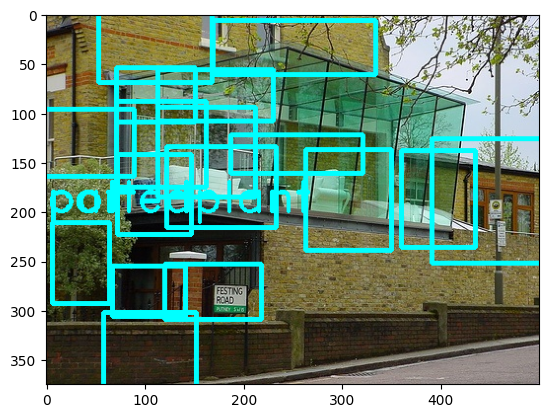

In [16]:
load_img = cv2.imread(
    os.path.join(DATA_DIR, "VOCdevkit_test/VOC2007/JPEGImages/000003.jpg")
)
load_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
resize_img = cv2.resize(load_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = resize_img.astype(np.float32)
np_img = (np_img / 255.0) * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
out = process_outputs(y_pred)
out = zip(*out)

for xmin, ymin, xmax, ymax, class_num, conf in out:
    class_name = CLASSES_NAME[class_num]
    xmin = xmin * (load_img.shape[1] / IMAGE_SIZE)
    ymin = ymin * (load_img.shape[0] / IMAGE_SIZE)
    xmax = xmax * (load_img.shape[1] / IMAGE_SIZE)
    ymax = ymax * (load_img.shape[0] / IMAGE_SIZE)

    cv2.rectangle(
        load_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3
    )
    cv2.putText(load_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(load_img)


可以看到圖片上有著很多不明所以的框框，然而這樣分數卻會比少量準確框框的表現更好。

## Conclusion

這次 Competition 真的花了我們很多時間，我們第一個禮拜基本都是在嘗試刻出 YOLOv4，然而我們最後沒有成功。而後續就是一直嘗試 Data augmentation，然而我們直到禮拜三，都沒能訓練出一個成功的模型，直到最後才成功。我們發現我們一開始用的 Augmentation 太複雜了，各類增強＋YOLOv4 中的馬賽克增強，因此反而可能導致模型訓練的不好，其中也有可能有部份原因是 YOLOv1 的整體架構沒辦法接受那麼複雜的圖片。不過能夠在最後找到問題也算是運氣不錯。

